Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```



In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Do train/validate/test split with the Tanzania Waterpumps data.
train, val = train_test_split(train, train_size=.8, test_size=.2, stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [4]:
train.latitude.value_counts().head()

-2.000000e-08    1442
-2.519950e+00       2
-2.489378e+00       2
-6.991294e+00       2
-7.056923e+00       2
Name: latitude, dtype: int64

In [5]:
train.longitude.value_counts().head()

0.000000     1442
39.095684       2
39.092062       2
37.543401       2
39.103752       2
Name: longitude, dtype: int64

In [6]:
#  Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. 
#  (For example, what other columns have zeros and shouldn't? What other columns are duplicates, or nearly duplicates? 
#  Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump 
#  construction to waterpump inspection?)

def wrangle(X):
    '''Wrangle train, validate and test sets'''
    
    # this will prevent SettingWithCopyWarning
    X = X.copy()
    
    # latitude and longitude have some missing values coded as 0s (or very small near-zeros.)
    # I'm going to replace those with nulls for now and later decide how to impute them
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    cols_with_zeros = ['latitude', 'longitude', 'construction_year', 'gps_height',
                      ]
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        

    # quantity and quantity_group are the same data, so we don't need both    
    # recorded_by only has one value, which gives us literally no variance
    # num_private doesnt seem to help the model
    # wpt_name has very high cardinality
    # extraction_type_group and extraction_type are both similar to extraction_type_class
    # payment_type is similar to payment
    # water_quality is similar to quality_group
    # basin and scheme_management don't help the model
    # waterpoint_type_gruop is similar to waterpoint_type
    # quantity_group is a duplicate of quantity
    # installer has very high cardinality
    X = X.drop(columns=['quantity_group', 'recorded_by', 'num_private', 'wpt_name',
              'extraction_type_group', 'extraction_type', 'payment_type', 'water_quality',
              'basin', 'scheme_management', 'waterpoint_type_group', 'installer'])
    
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [7]:
#  Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

# status_group is what we want to predict
target = 'status_group'

# we can't train our model using the target, that'd be silly
train_features = train.drop(columns=[target])

# a list of our numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# now a series with the cardinality of our non-numeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# a list of all categorical features with low cardinality
categorical_features = cardinality[cardinality <= 30].index.tolist()

# Slap those lists together
features = numeric_features + categorical_features
print(features)

['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year', 'region', 'public_meeting', 'permit', 'extraction_type_class', 'management', 'management_group', 'payment', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type']


In [8]:
# time to arrange our data in to a features matrix and target vector

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [9]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(min_samples_leaf=3, max_depth=10, random_state=42)
)

dt.fit(X_train, y_train)

#  Get your validation accuracy score.
print('Training Accuracy', dt.score(X_train, y_train))
print('Validation Accuracy', dt.score(X_val, y_val))

Training Accuracy 0.7565656565656566
Validation Accuracy 0.7382154882154882


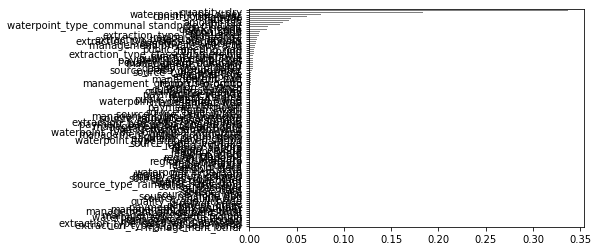

In [10]:
#  Get and plot your feature importances.

model = dt.named_steps['decisiontreeclassifier']
encoder = dt.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
importances.sort_values().plot.barh(color='grey')

In [11]:
importances.sort_values()

management_other                               0.000000
extraction_type_class_rope pump                0.000000
extraction_type_class_wind-powered             0.000000
management_parastatal                          0.000000
management_unknown                             0.000000
waterpoint_type_cattle trough                  0.000000
management_other - school                      0.000000
management_trust                               0.000000
management_group_parastatal                    0.000000
management_group_other                         0.000000
payment_pay annually                           0.000000
payment_other                                  0.000000
permit_False                                   0.000000
quality_group_fluoride                         0.000000
source_shallow well                            0.000000
source_machine dbh                             0.000000
source_hand dtw                                0.000000
source_lake                                    0

In [18]:
#  Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue Submit Predictions button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
y_pred = dt.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-01.csv', index=False)

In [ ]:
#  Commit your notebook to your fork of the GitHub repo.